
# **1. Product 概要**
---

1.1  名称  

---

*  simpleNN  
  
---

1.2  製作目論見  

---
*  ニューラルネットワークによる機械学習(初歩)の習得  
*  Pythonの習得
    *  Python選定理由
        *  直感的な数値計算パッケージが活用できるため (特に行列演算)
        *  数値計算結果の可視化パッケージが充実しているため  
*  ニューラルネットワークによる学習経過を閲覧者に楽しんでいただく  


# **2. ニューラルネットワーク概要図**
---

適当なお絵描きツールで大雑把に全体のイメージ(フロー)を織り込む(機能ブロック図のポンチ絵版)  
*  図面構成  
    *  訓練(入力)データ図面(一例) ⇒ NN ⇒ 正解(教師)図面に変更する  
---
*  レイヤの説明 ⇒ 各レイヤを枠で囲って説明  
*  前方・後方伝搬 ⇒ 基本図形の矢印を使って説明
*  誤差判定箇所 ⇒ 出力レイヤに損失関数記載して説明    
---
*  損失関数, 勾配降下法, bias broadcasting, weight, 活性化関数  ⇒ 定性的(目的)説明 + 数式で説明 
*  matrix計算 ⇒ matrixを使うことで、codeの記載が直感的かつシンプルになることを説明  
---
*  バッチ ⇒ 計算効率を向上させるため、計算を分割して実施すると簡単に説明     
*  バッチサイズ ⇒ 本例は1バッチ ⇒ 1バッチの場合は(例外的に)オンライン学習となると説明
*  エポック数 ⇒ バッチ当たりの学習回数と説明  
---

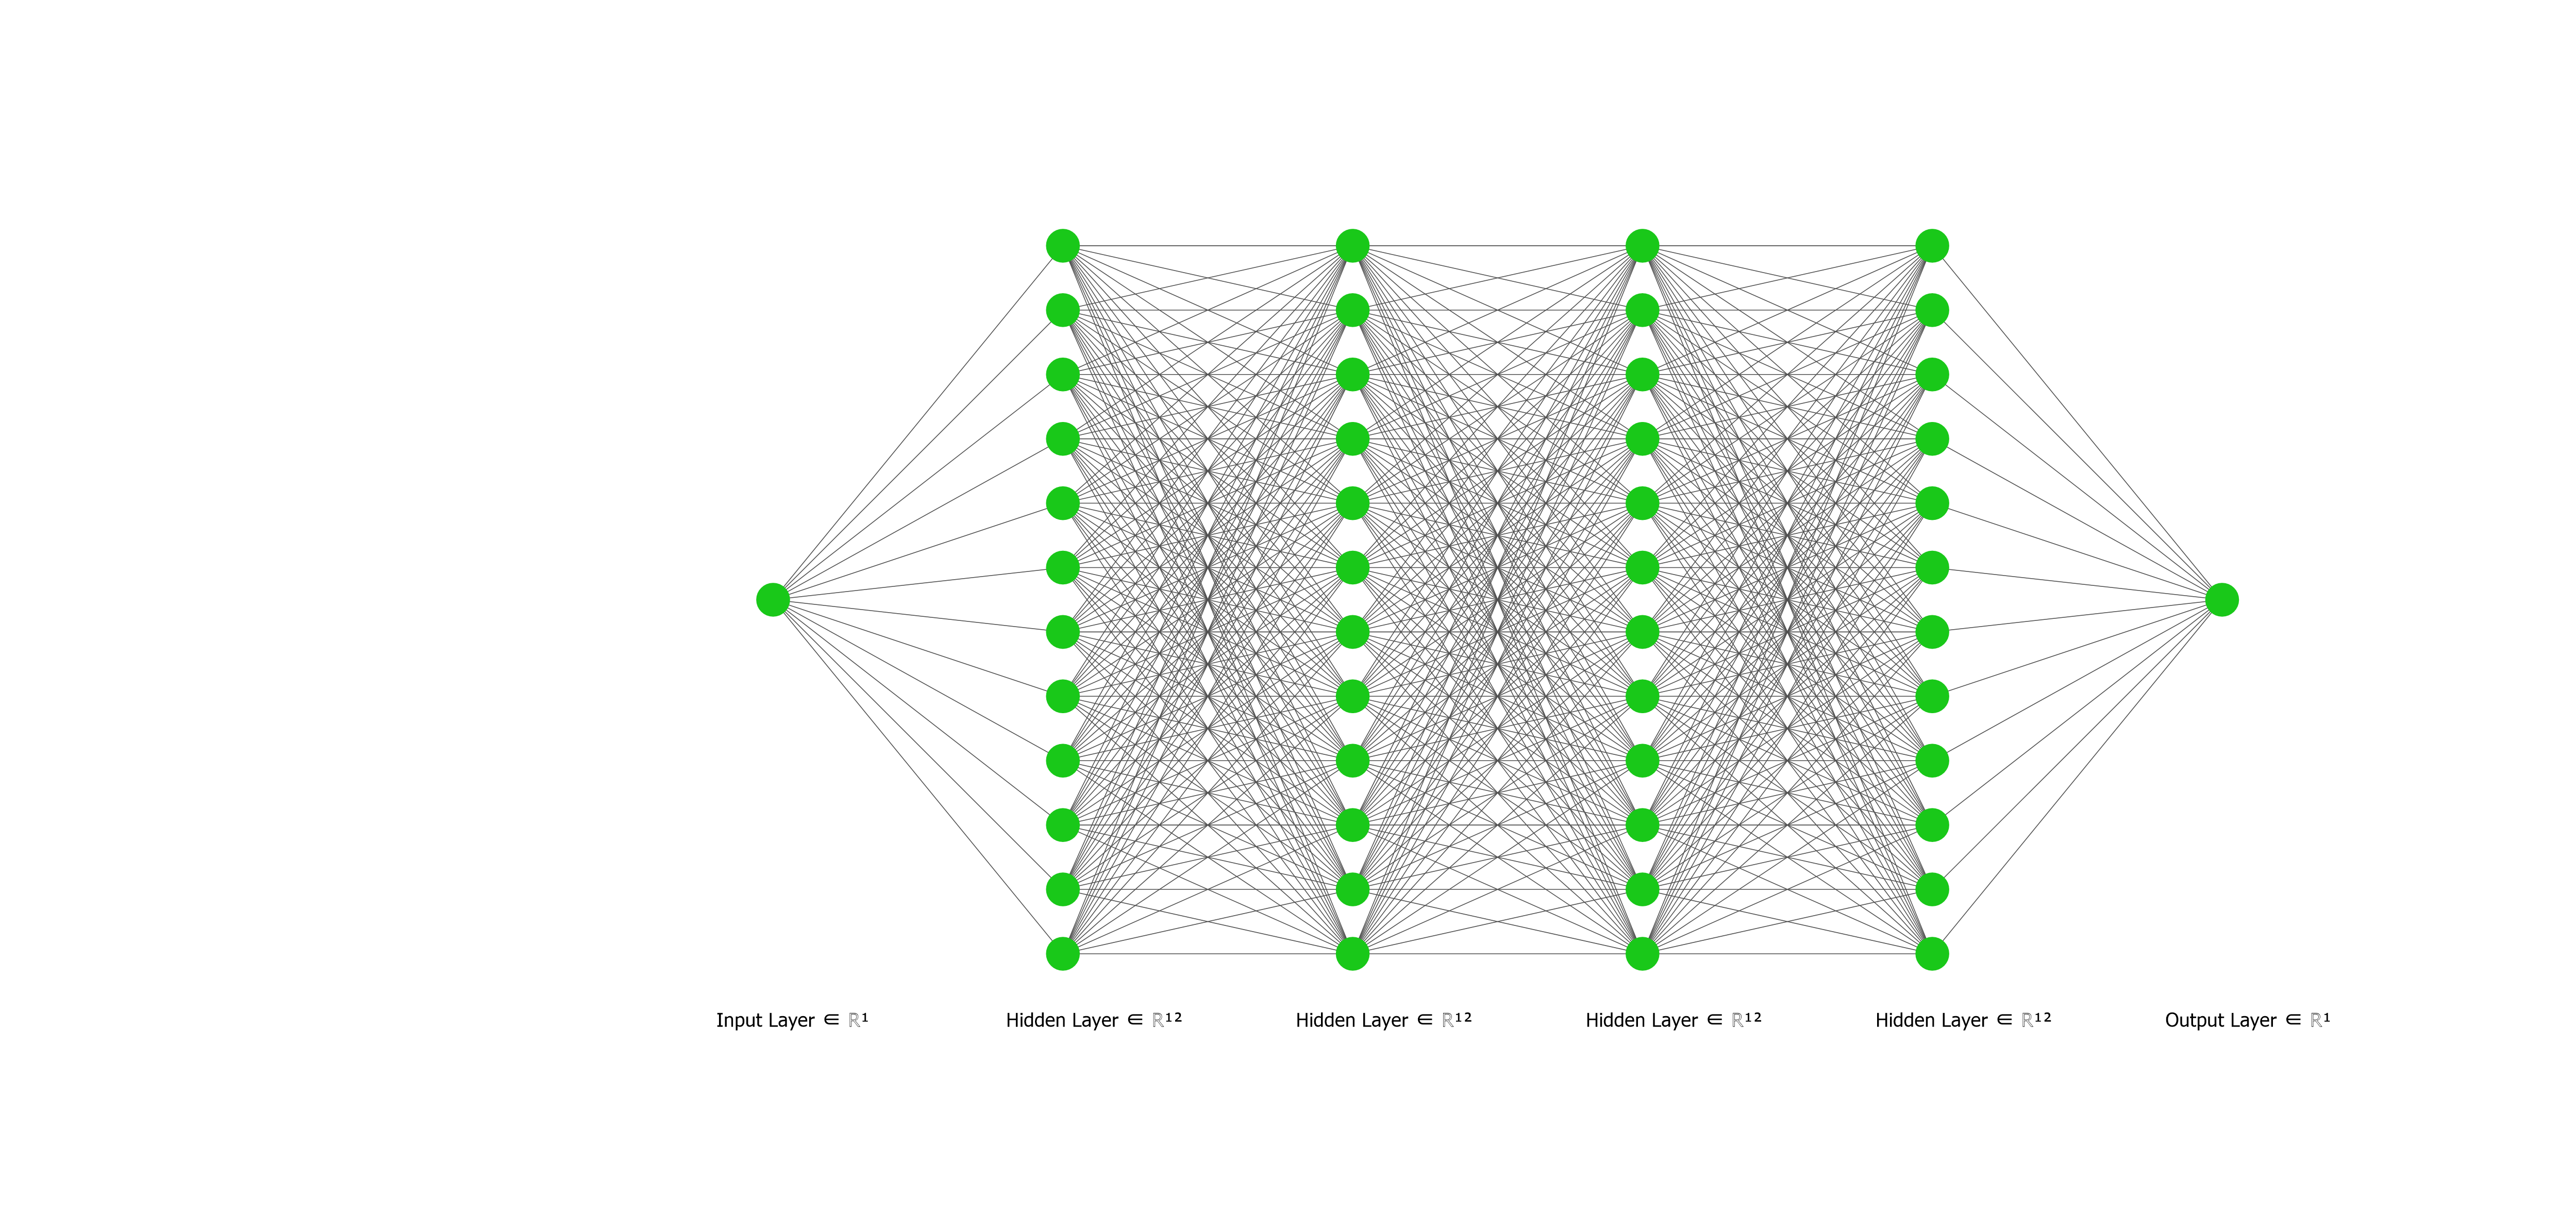


# **3. Product内部の概説**

---

3.1 数学的説明に関する前提    

---

*  機械学習の説明を補間する目的として数学的表現を使用  
    (基礎数学の説明は割愛)  

---

3.2 対象とする問題  

---

*  機械学習は以下の二種類に大別される。  
    *  回帰問題 ⇒ データ傾向から連続的な数値を予測する。 (prediction)  (ex. 雇用指数, 株価, ...)
    *  分類問題 ⇒ 特徴を抽出し分類する。  (clustering)  (ex. 男性, 女性, 中性, ...)

*  今回扱う問題  
    *  回帰問題  

---

3.3 学習法  

---

*  ニューラルネットワーク(NN)による教師付学習(SVM)  
  *  前方伝搬(入力レイヤから出力レイヤへ向かって訓練データを伝搬)  
  *  誤差修正(出力レイヤで誤差を計測)  
    *  誤差の算出 ⇒ 出力レイヤに、損失関数として最小二乗和を適用し算出
    *  勾配降下法 ⇒ 1階(偏)微分  
    *  誤差逆伝搬 ⇒ 出力レイヤから入力レイヤへニューラルネットワークを遡って誤差を伝搬  
    *  バッチサイズ ⇒ 1バッチ (オンラインバッチ)  
*  学習過程の特異さに関して  
  *  生物では発見されていない方法  
    *  制御工学のフィードバックループとも異なる学習(制御)方法  
        

---

3.3 行列演算モジュールとレイヤ構成による系の構成  

---
*  行列演算モジュール(inculded in Numpy)を利用することで行列演算が直感的かつ簡素に実装可  
*  各レイヤにおいて、コード再利用することで簡素に実装可能(inheritance, iteration, etc)  
*  個人的な所感としては、上記2点により直感的で素直に実装できると判断している。  

---
**変更点覚書  (説明に役立つ部分は織り込む)**  
---
*  plot方法  
    *  Error(誤差率) => Precision(精度) かつ % 表記 (閲覧者が直感的に分かりやすい)  
*  教師データ(青ダッシュ線)変更
    * 理由 => sin()の単項式はややダサすぎる。閲覧者も興味を抱きにくそう。  

    After  
    `correct_data = np.sin(input_data) + np.cos(2 * input_data)`
  
    Before  
    `correct_data = np.sin(input_data)`  
*  Epoch数 ⇒ 8,001(収束がよくないので増加させた。)
      *  表示インターバル ⇒ 400学習毎 (1学習: 前方伝搬 x 1回 + 後方伝搬 x 1回 (ニューラルネットワークを一往復するイメージ))  
*  入力データ数 ⇒ 50個 (x=1～+1, tick=0.04)




  

# **3. Pythonによる実装**

**(A series of results will show up anytime you make it fire.  )**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -- generate original input data and define correct data --
input_data = np.linspace(-np.pi, np.pi)  # original input dataset
correct_data = np.sin(input_data) + np.sqrt(2) * np.cos(4 * input_data) # correct dataset
input_data = input_data/np.pi            # normalize the data realm from -1.0 to 1.0
n_data = len(correct_data)               # total numbers(lengths) of data

# -- config --
n_in = 1   # the number of neurons at the input layer
n_mid = 12 # the number of neurons at the hidden layers
n_out = 1  # the number of neurons at the output layer

wb_width = 0.59911 # initial width of weight and bias
eta = 0.11255      # initial learning coefficient
epoch = 8001      # online batch, meaning its size is one.
interval = 400    # initial monitoring interval

# -- super-class --
class BaseLayer:
    def __init__(self, n_upper, n): #initializer (n_upper: the numbers of neurons in the upper(next) layer, n: the numbers of neurons in its own layer)
        self.w = wb_width * np.random.randn(n_upper, n)  # weight matrix (normalized)
        self.b = wb_width * np.random.randn(n)  # bias vector (normalized)

    def update(self, eta): # method for updating weight and bias
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b

# -- sub-class #1--
# -- hiddenlayer--
class HiddenLayer(BaseLayer):
    def forward(self, x):  # method for foreward-propagation
        self.x = x
        u = np.dot(x, self.w) + self.b # u = [X][W] +[B]
        self.y = 1/(1+np.exp(-u))  # use sigmoid function for activaion

    def backward(self, grad_y):  # method for backward-propagation
        delta = grad_y * (1-self.y)*self.y  # delta = gradient of sigmoid function
        self.grad_w = np.dot(self.x.T, delta) # take gradient of weight backward
        self.grad_b = np.sum(delta, axis=0) # take sum of bias-broadcasting backward
        self.grad_x = np.dot(delta, self.w.T) # take gradient of data input in this layer

# -- sub-class #2--
# -- output layer --
class OutputLayer(BaseLayer):
    def forward(self, x):  # method for foreward-propagation
        self.x = x 
        u = np.dot(x, self.w) + self.b  # [u] = [X][W] + [B]
        self.y = u   # use identity function for activation [Y] = [u] = [X][W] + [B]  

    def backward(self, t):  # method for backward-propagation
        delta = self.y - t # [delta] = [Y] - [T] (raw loss)
        self.grad_w = np.dot(self.x.T, delta) # take gradient of weight backward; [grad_W] = [X]T[DELTA]
        self.grad_b = np.sum(delta, axis=0) # take sum of bias-broadcasting backward; grad_b = sum(DELTA)
        self.grad_x = np.dot(delta, self.w.T) # take gradient of data input in this layer; [grad_B] = [DELTA][W]T


# -- initializing each layer --
hidden_layer1 = HiddenLayer(n_in, n_mid)
hidden_layer2 = HiddenLayer(n_mid, n_mid)
hidden_layer3 = HiddenLayer(n_mid, n_mid)
hidden_layer4 = HiddenLayer(n_mid, n_mid)

output_layer = OutputLayer(n_mid, n_out)

# -- start learning --
for i in range(epoch):

    # shffle the indecies of arrays of input and their corresponding correct data to make learning order randamized
    index_random = np.arange(n_data)
    np.random.shuffle(index_random)

    # preparation for plotting the results
    total_error = 0
    plot_x = []
    plot_y = []

    for idx in index_random:

        x = input_data[idx]  # original input dataset
        t = correct_data[idx]  # correct dataset

        # foreward-propagation
        hidden_layer1.forward(np.array([[x]]))  # treat input dataset as a matrix(that consists of just one number, though.)
        hidden_layer2.forward(hidden_layer1.y)
        hidden_layer3.forward(hidden_layer2.y)
        hidden_layer4.forward(hidden_layer3.y)
        output_layer.forward(hidden_layer4.y)

        # backward-propagation
        output_layer.backward(np.array([[t]]))  # treat correct dataset as a matrix(that consists of just one number, though.)
        hidden_layer4.backward(output_layer.grad_x)
        hidden_layer3.backward(hidden_layer4.grad_x)
        hidden_layer2.backward(hidden_layer3.grad_x)
        hidden_layer1.backward(hidden_layer2.grad_x)

        # update weight and bias (method of update defined in the class BaseLayer)
        hidden_layer1.update(eta)
        hidden_layer2.update(eta)
        hidden_layer3.update(eta)
        hidden_layer4.update(eta)
        output_layer.update(eta)

        if i%interval == 0:

            y = output_layer.y[0][0]  # get a number (from matrix) as a learned one in the output layer.

            # error estimation by loss function (apply mean square error)
            total_error += 1.0/2.0*np.sum(np.square(y - t))

            # store outputs learned
            plot_x.append(x)
            plot_y.append(y)

    if i%interval == 0:

        # plot outpus
        plt.plot(input_data, correct_data, linestyle="dashed")
        plt.scatter(plot_x, plot_y, marker="+")
        plt.show()

        # print epoch number and accuracy
        print("Epoch:" + str(i) + "/" + str(epoch), "Accuracy:" + str(((1 - total_error/n_data)) * 100) + "%")